In [1]:
import pandas as pd
import numpy as np
np.set_printoptions(suppress=True) # Suppress scientific notation where possible

from ast import literal_eval

import re
import string

In [2]:
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
from nltk.tag import pos_tag
from nltk.chunk import ne_chunk

In [4]:
import spacy

In [5]:
import gensim
from gensim.parsing.preprocessing import STOPWORDS

In [6]:
from nltk.stem import PorterStemmer, SnowballStemmer, LancasterStemmer

In [7]:
from sklearn.decomposition import TruncatedSVD

from scipy.sparse import csr_matrix

from sklearn.preprocessing import StandardScaler

In [8]:
import seaborn as sns

from matplotlib import pyplot as plt
%config InlineBackend.figure_formats = ['retina']  # or svg
%matplotlib inline

In [9]:
# Make some room to see stuff (i.e. drop display limits on Pandas rows & cols - be careful w/ big df's!)

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', None)

## 1) Read in the data

In [10]:
movies = pd.read_csv('final_dataset.csv', lineterminator='\n', index_col=0)
print(movies.shape)
movies.head()

(47723, 8)


,movieId,tmdbId,imdbId,title,genres,overview,director,actors
0,1,862,114709,Toy Story,"['Adventure', 'Animation', 'Children', 'Comedy...","Led by Woody, Andy's toys live happily in his ...",john_lasseter,"['tom_hanks', 'tim_allen', 'don_rickles', 'jim..."
1,2,8844,113497,Jumanji,"['Adventure', 'Children', 'Fantasy']",When siblings Judy and Peter discover an encha...,joe_johnston,"['robin_williams', 'kirsten_dunst', 'bradley_p..."
2,3,15602,113228,Grumpier Old Men,"['Comedy', 'Romance']",A family wedding reignites the ancient feud be...,howard_deutch,"['walter_matthau', 'jack_lemmon', 'ann-margret..."
3,4,31357,114885,Waiting to Exhale,"['Comedy', 'Drama', 'Romance']","Cheated on, mistreated and stepped on, the wom...",forest_whitaker,"['whitney_houston', 'angela_bassett', 'loretta..."
4,5,11862,113041,Father of the Bride Part II,['Comedy'],Just when George Banks has recovered from his ...,charles_shyer,"['steve_martin', 'diane_keaton', 'martin_short..."


#### Lists in columns got turned into text strings during save to csv; need to undo that

In [11]:
movies['genres'] = movies['genres'].map(literal_eval)
movies['actors'] = movies['actors'].map(literal_eval)
movies.head()

,movieId,tmdbId,imdbId,title,genres,overview,director,actors
0,1,862,114709,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]","Led by Woody, Andy's toys live happily in his ...",john_lasseter,"[tom_hanks, tim_allen, don_rickles, jim_varney]"
1,2,8844,113497,Jumanji,"[Adventure, Children, Fantasy]",When siblings Judy and Peter discover an encha...,joe_johnston,"[robin_williams, kirsten_dunst, bradley_pierce..."
2,3,15602,113228,Grumpier Old Men,"[Comedy, Romance]",A family wedding reignites the ancient feud be...,howard_deutch,"[walter_matthau, jack_lemmon, ann-margret, sop..."
3,4,31357,114885,Waiting to Exhale,"[Comedy, Drama, Romance]","Cheated on, mistreated and stepped on, the wom...",forest_whitaker,"[whitney_houston, angela_bassett, loretta_devi..."
4,5,11862,113041,Father of the Bride Part II,[Comedy],Just when George Banks has recovered from his ...,charles_shyer,"[steve_martin, diane_keaton, martin_short, kim..."


## 2) Tokenize the 'overview' column

#### Let's continue to brush aside the Named Entity issue in 'overview'

#### Start by removing digits, capital letters and punctuation

In [12]:
alpha = lambda x: re.sub('\w*\d\w*', ' ', x)
punc_and_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

movies['plot_tokens'] = movies['overview'].map(alpha).map(punc_and_lower)
movies.head()

,movieId,tmdbId,imdbId,title,genres,overview,director,actors,plot_tokens
0,1,862,114709,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]","Led by Woody, Andy's toys live happily in his ...",john_lasseter,"[tom_hanks, tim_allen, don_rickles, jim_varney]",led by woody andy s toys live happily in his ...
1,2,8844,113497,Jumanji,"[Adventure, Children, Fantasy]",When siblings Judy and Peter discover an encha...,joe_johnston,"[robin_williams, kirsten_dunst, bradley_pierce...",when siblings judy and peter discover an encha...
2,3,15602,113228,Grumpier Old Men,"[Comedy, Romance]",A family wedding reignites the ancient feud be...,howard_deutch,"[walter_matthau, jack_lemmon, ann-margret, sop...",a family wedding reignites the ancient feud be...
3,4,31357,114885,Waiting to Exhale,"[Comedy, Drama, Romance]","Cheated on, mistreated and stepped on, the wom...",forest_whitaker,"[whitney_houston, angela_bassett, loretta_devi...",cheated on mistreated and stepped on the wom...
4,5,11862,113041,Father of the Bride Part II,[Comedy],Just when George Banks has recovered from his ...,charles_shyer,"[steve_martin, diane_keaton, martin_short, kim...",just when george banks has recovered from his ...


In [13]:
movies['genres'] = movies['genres'].map(lambda x: [el.lower() for el in x])
movies.head()

,movieId,tmdbId,imdbId,title,genres,overview,director,actors,plot_tokens
0,1,862,114709,Toy Story,"[adventure, animation, children, comedy, fantasy]","Led by Woody, Andy's toys live happily in his ...",john_lasseter,"[tom_hanks, tim_allen, don_rickles, jim_varney]",led by woody andy s toys live happily in his ...
1,2,8844,113497,Jumanji,"[adventure, children, fantasy]",When siblings Judy and Peter discover an encha...,joe_johnston,"[robin_williams, kirsten_dunst, bradley_pierce...",when siblings judy and peter discover an encha...
2,3,15602,113228,Grumpier Old Men,"[comedy, romance]",A family wedding reignites the ancient feud be...,howard_deutch,"[walter_matthau, jack_lemmon, ann-margret, sop...",a family wedding reignites the ancient feud be...
3,4,31357,114885,Waiting to Exhale,"[comedy, drama, romance]","Cheated on, mistreated and stepped on, the wom...",forest_whitaker,"[whitney_houston, angela_bassett, loretta_devi...",cheated on mistreated and stepped on the wom...
4,5,11862,113041,Father of the Bride Part II,[comedy],Just when George Banks has recovered from his ...,charles_shyer,"[steve_martin, diane_keaton, martin_short, kim...",just when george banks has recovered from his ...


#### Tokenize plot summaries - start with simple NLTK word_tokenize:

In [14]:
movies['plot_tokens'] = movies['plot_tokens'].map(word_tokenize)
movies.head()

,movieId,tmdbId,imdbId,title,genres,overview,director,actors,plot_tokens
0,1,862,114709,Toy Story,"[adventure, animation, children, comedy, fantasy]","Led by Woody, Andy's toys live happily in his ...",john_lasseter,"[tom_hanks, tim_allen, don_rickles, jim_varney]","[led, by, woody, andy, s, toys, live, happily,..."
1,2,8844,113497,Jumanji,"[adventure, children, fantasy]",When siblings Judy and Peter discover an encha...,joe_johnston,"[robin_williams, kirsten_dunst, bradley_pierce...","[when, siblings, judy, and, peter, discover, a..."
2,3,15602,113228,Grumpier Old Men,"[comedy, romance]",A family wedding reignites the ancient feud be...,howard_deutch,"[walter_matthau, jack_lemmon, ann-margret, sop...","[a, family, wedding, reignites, the, ancient, ..."
3,4,31357,114885,Waiting to Exhale,"[comedy, drama, romance]","Cheated on, mistreated and stepped on, the wom...",forest_whitaker,"[whitney_houston, angela_bassett, loretta_devi...","[cheated, on, mistreated, and, stepped, on, th..."
4,5,11862,113041,Father of the Bride Part II,[comedy],Just when George Banks has recovered from his ...,charles_shyer,"[steve_martin, diane_keaton, martin_short, kim...","[just, when, george, banks, has, recovered, fr..."


In [15]:
movies['director'] = movies['director'].map(lambda x: [x])
movies.head()

,movieId,tmdbId,imdbId,title,genres,overview,director,actors,plot_tokens
0,1,862,114709,Toy Story,"[adventure, animation, children, comedy, fantasy]","Led by Woody, Andy's toys live happily in his ...",[john_lasseter],"[tom_hanks, tim_allen, don_rickles, jim_varney]","[led, by, woody, andy, s, toys, live, happily,..."
1,2,8844,113497,Jumanji,"[adventure, children, fantasy]",When siblings Judy and Peter discover an encha...,[joe_johnston],"[robin_williams, kirsten_dunst, bradley_pierce...","[when, siblings, judy, and, peter, discover, a..."
2,3,15602,113228,Grumpier Old Men,"[comedy, romance]",A family wedding reignites the ancient feud be...,[howard_deutch],"[walter_matthau, jack_lemmon, ann-margret, sop...","[a, family, wedding, reignites, the, ancient, ..."
3,4,31357,114885,Waiting to Exhale,"[comedy, drama, romance]","Cheated on, mistreated and stepped on, the wom...",[forest_whitaker],"[whitney_houston, angela_bassett, loretta_devi...","[cheated, on, mistreated, and, stepped, on, th..."
4,5,11862,113041,Father of the Bride Part II,[comedy],Just when George Banks has recovered from his ...,[charles_shyer],"[steve_martin, diane_keaton, martin_short, kim...","[just, when, george, banks, has, recovered, fr..."


#### Combine all tokens into one 'corpus' column

In [16]:
cols = ['genres', 'director', 'actors', 'plot_tokens']

movies['corpus'] = ''

for n, row in movies.iterrows():
    val = ''
    for col in cols:
        val += ' '.join(row[col])
        val += ' '
    movies.at[n,'corpus'] = val

In [17]:
movies.head()

,movieId,tmdbId,imdbId,title,genres,overview,director,actors,plot_tokens,corpus
0,1,862,114709,Toy Story,"[adventure, animation, children, comedy, fantasy]","Led by Woody, Andy's toys live happily in his ...",[john_lasseter],"[tom_hanks, tim_allen, don_rickles, jim_varney]","[led, by, woody, andy, s, toys, live, happily,...",adventure animation children comedy fantasy jo...
1,2,8844,113497,Jumanji,"[adventure, children, fantasy]",When siblings Judy and Peter discover an encha...,[joe_johnston],"[robin_williams, kirsten_dunst, bradley_pierce...","[when, siblings, judy, and, peter, discover, a...",adventure children fantasy joe_johnston robin_...
2,3,15602,113228,Grumpier Old Men,"[comedy, romance]",A family wedding reignites the ancient feud be...,[howard_deutch],"[walter_matthau, jack_lemmon, ann-margret, sop...","[a, family, wedding, reignites, the, ancient, ...",comedy romance howard_deutch walter_matthau ja...
3,4,31357,114885,Waiting to Exhale,"[comedy, drama, romance]","Cheated on, mistreated and stepped on, the wom...",[forest_whitaker],"[whitney_houston, angela_bassett, loretta_devi...","[cheated, on, mistreated, and, stepped, on, th...",comedy drama romance forest_whitaker whitney_h...
4,5,11862,113041,Father of the Bride Part II,[comedy],Just when George Banks has recovered from his ...,[charles_shyer],"[steve_martin, diane_keaton, martin_short, kim...","[just, when, george, banks, has, recovered, fr...",comedy charles_shyer steve_martin diane_keaton...


In [18]:
movies['corpus'][0]

'adventure animation children comedy fantasy john_lasseter tom_hanks tim_allen don_rickles jim_varney led by woody andy s toys live happily in his room until andy s birthday brings buzz lightyear onto the scene afraid of losing his place in andy s heart woody plots against buzz but when circumstances separate buzz and woody from their owner the duo eventually learns to put aside their differences '

#### Build a Stemmer and Stopword function for use w/ the Vectorizer; Let's use a "better" English stopword list than the NLTK default

In [19]:
# Using the "better" Gensim English STOPWORDS list instead of the NLTK default list

stemmer = SnowballStemmer('english')

def prep(word, stemmer=stemmer):
    
    stopwords = list(STOPWORDS)
        
    if word.lower() in stopwords:
        return None
    
    elif stemmer is None:
        return word.lower()
    
    else:
        return stemmer.stem(word)

In [44]:
# CountVectorizer(stop_words=None, max_df=0.7, )

cv1 = CountVectorizer(stop_words=list(STOPWORDS), preprocessor=prep, ngram_range=(1, 1), min_df=0.045)

X_cv1 = cv1.fit_transform(movies['corpus'])

doc_term = pd.DataFrame(X_cv1.toarray(), columns=cv1.get_feature_names())
doc_term.shape

(47723, 48)

In [45]:
doc_term.head()

,action,adventure,children,comedy,crime,daughter,day,documentary,drama,family,fantasy,father,fi,film,finds,friend,friends,girl,group,help,home,horror,life,lives,love,man,mother,mystery,new,old,romance,school,sci,son,soon,story,takes,thriller,time,town,war,way,wife,woman,world,year,years,young
0,0,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
2,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


#### Now apply dimensionality reduction to the dataset

In [46]:
svd = TruncatedSVD(n_components=40, n_iter=50, random_state=42)
svd.fit(X_cv1.T)

TruncatedSVD(n_components=40, n_iter=50, random_state=42)

In [47]:
print(svd.explained_variance_ratio_)

print(svd.explained_variance_ratio_.sum())

[0.0784542  0.06476871 0.04690691 0.03859985 0.03759941 0.03412601
 0.03304503 0.03193738 0.02957435 0.02818957 0.02734953 0.02653519
 0.02637717 0.0244629  0.02170449 0.02138178 0.02048764 0.02058701
 0.01890236 0.01826001 0.01777356 0.01760138 0.01754522 0.01701433
 0.01654204 0.01612864 0.01540683 0.01445105 0.01431614 0.01396773
 0.01352625 0.01343765 0.01296808 0.01235543 0.01216337 0.01198953
 0.01183377 0.01151167 0.01143019 0.01129644]
0.9325088022642863


In [48]:
svd.components_.T.shape

(47723, 40)

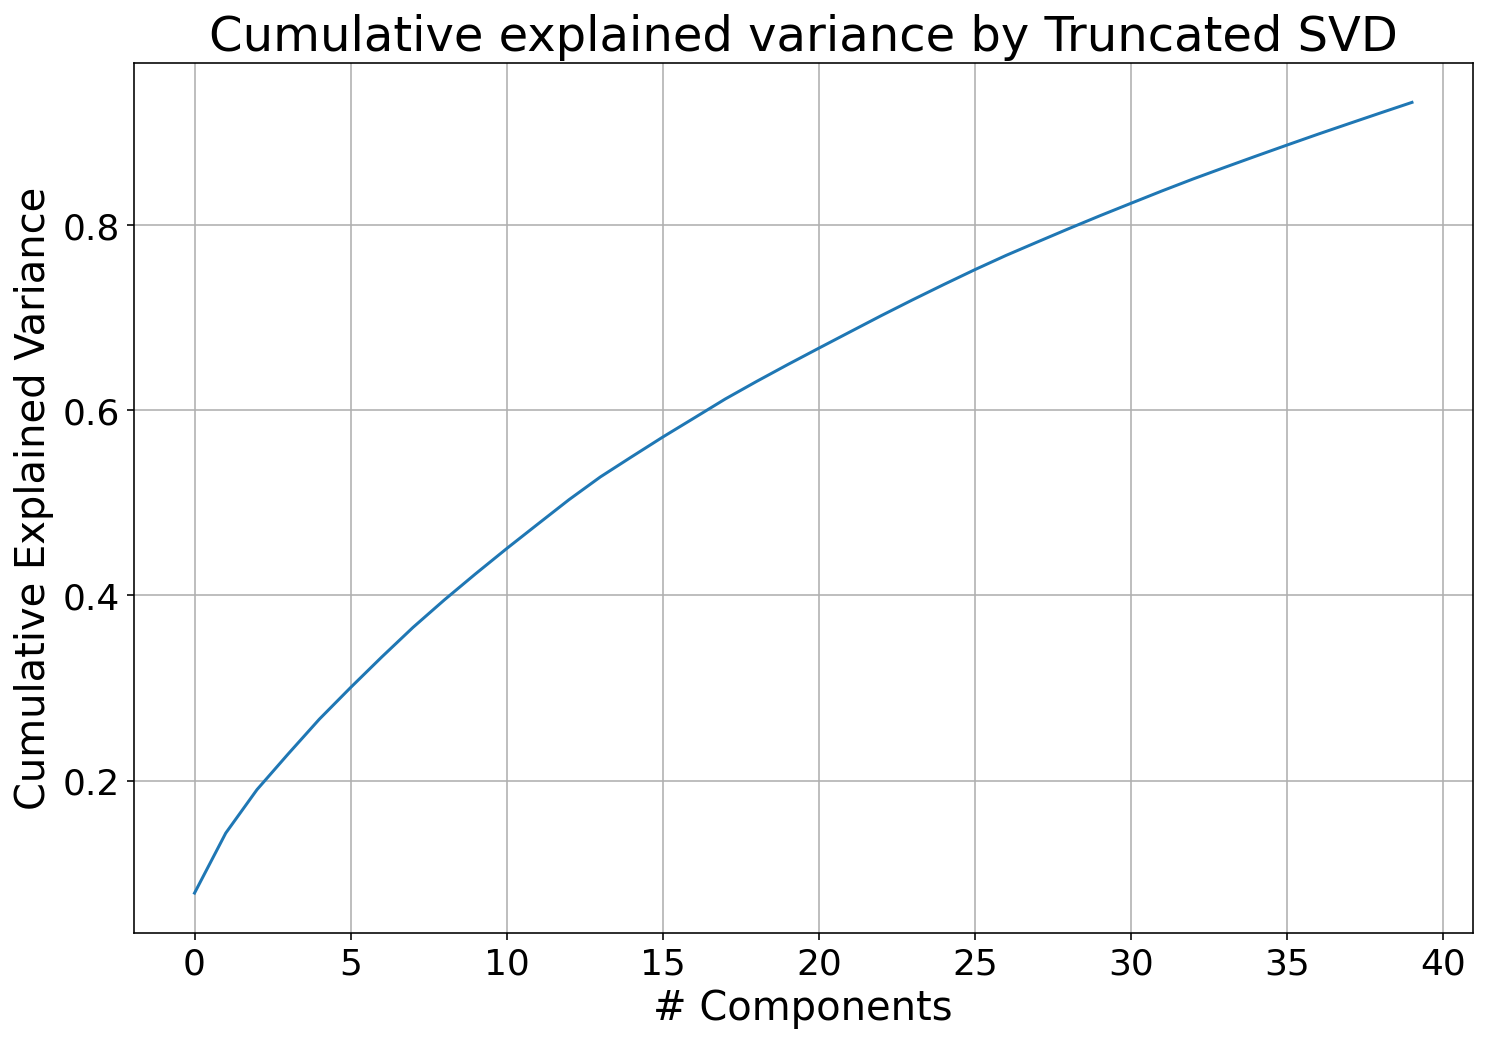

In [49]:
plt.figure(figsize=(12, 8))
plt.plot(np.cumsum(svd.explained_variance_ratio_))
plt.xlabel('# Components', size=20)
plt.ylabel('Cumulative Explained Variance', size=20)
plt.xticks(size=18)
plt.yticks(size=18)
plt.title('Cumulative explained variance by Truncated SVD', size=24)
plt.grid();

In [50]:
mat = pd.DataFrame(data=svd.components_.T, index=movies.index)
mat

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
0,0.002492,0.007710,0.001687,-0.001755,0.003104,0.000800,0.003185,-0.002462,-0.002598,-0.002113,-0.003308,-0.000412,-0.005128,0.000487,0.002398,-0.000273,0.003037,0.015080,0.006399,-0.004193,-0.002595,0.001089,0.002206,-0.001566,0.005574,-0.002608,-0.003023,-0.000454,0.000351,-0.000897,-0.001601,0.002167,-0.003506,0.001367,0.000911,-0.001056,-0.002847,-0.000338,0.000216,-0.001140
1,0.001829,0.001164,0.003365,0.002306,0.005779,0.005576,0.003730,-0.002887,-0.000614,-0.002812,-0.002791,0.000046,-0.002951,0.002315,0.004771,-0.005523,0.010896,0.015799,0.001596,-0.001222,-0.004240,-0.000024,0.006423,-0.001544,0.001992,0.001936,0.001053,-0.004255,0.014479,0.000439,-0.004597,0.000513,-0.004545,0.000246,-0.000964,-0.001546,-0.002850,-0.000722,0.000214,-0.000639
2,0.003614,0.007966,-0.001967,-0.001436,-0.000834,-0.000132,0.002080,-0.002451,0.003380,-0.001135,0.007857,0.000007,-0.003219,-0.005730,-0.006128,-0.007503,0.002205,-0.001523,0.000827,-0.000094,0.007095,-0.005457,-0.003466,-0.003528,-0.007496,0.001718,-0.006925,-0.000547,-0.001964,-0.000712,-0.002450,-0.000121,-0.002673,0.000309,0.000484,0.000555,-0.000613,-0.001635,-0.000066,-0.000767
3,0.006850,0.004463,-0.004142,-0.005544,-0.002586,0.000559,-0.002639,0.000803,-0.001704,-0.001060,-0.000229,-0.007215,0.006105,-0.004401,-0.005190,-0.002809,0.001461,0.003932,-0.001823,0.003619,-0.001570,-0.001766,-0.001986,-0.002817,0.000182,-0.001900,-0.002186,-0.003699,-0.000691,0.000320,0.002640,-0.001586,0.012258,-0.008260,0.001739,-0.002854,0.001930,0.001528,-0.003069,-0.003545
4,0.002541,0.006654,-0.000130,-0.001708,-0.000382,-0.002641,0.002722,0.000532,-0.001726,0.001073,0.001838,-0.000644,0.000669,-0.000406,-0.000650,0.003522,0.001316,-0.000241,0.001479,-0.002865,0.002901,-0.002618,0.004307,0.003067,0.003778,0.012031,0.009265,0.004505,-0.005544,0.000147,0.000114,0.004955,0.001708,-0.004640,-0.013347,-0.000578,-0.001651,0.008708,-0.011234,-0.001199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47718,0.007333,-0.003046,-0.002935,0.005501,0.000279,-0.001036,0.016258,-0.003542,0.003452,-0.005636,-0.004413,-0.006092,0.002159,0.019730,-0.006715,0.009086,0.012236,-0.010921,0.000111,-0.004723,0.015665,-0.011263,-0.001789,-0.009995,-0.013404,0.005701,-0.013387,0.007644,0.011081,0.034425,0.009351,0.030714,-0.004769,0.005198,-0.003364,0.006035,0.004280,-0.016885,0.023967,-0.019146
47719,0.003475,0.013077,-0.000841,-0.005174,0.000738,-0.004845,0.001026,0.002305,-0.004000,0.003433,0.000980,-0.001346,0.000057,-0.000631,0.001373,0.002461,-0.000354,-0.000610,-0.000554,-0.003792,0.002333,-0.001416,0.002838,0.001809,0.003720,0.008960,0.006345,0.001144,-0.003820,-0.003569,-0.002985,0.000432,-0.000015,-0.000726,-0.001056,0.001964,-0.002074,-0.005291,0.001722,-0.003075
47720,0.004427,-0.004030,-0.002739,-0.001863,-0.005576,0.003995,0.000406,0.003298,-0.004496,0.003219,-0.005279,0.003894,-0.005154,-0.000427,0.000286,-0.001800,-0.002049,-0.001683,-0.001440,-0.002809,0.004073,0.002115,0.007112,0.000258,-0.001472,-0.005253,0.001263,-0.000245,-0.000715,-0.000437,-0.001692,-0.000549,-0.000140,-0.000621,-0.000828,-0.000319,-0.001038,-0.000339,0.000198,-0.000966
47721,0.004195,-0.003060,0.005359,-0.001770,0.002516,0.003163,0.002066,-0.004057,0.003189,0.007511,-0.008399,-0.011283,-0.005427,-0.005127,0.002197,-0.001476,0.000171,-0.001231,0.006600,0.003030,-0.002568,0.002053,0.002573,-0.003991,0.006418,-0.001311,-0.004493,0.001049,-0.000685,-0.006764,0.000548,0.007323,-0.000742,0.000961,-0.001447,-0.002721,-0.004331,-0.001668,0.001461,0.000214


#### Compute Cosine Similarities in this reduced space

In [51]:
del doc_term

cosine_sim = cosine_similarity(mat, mat)
del mat

print(cosine_sim.shape)
print(cosine_sim)
np.save('cosine_similarities.npy', cosine_sim)

(47723, 47723)
[[ 1.          0.65245948  0.0046835  ... -0.02180187  0.30420467
  -0.10138458]
 [ 0.65245948  1.         -0.0880579  ... -0.03938494  0.15790808
  -0.09557999]
 [ 0.0046835  -0.0880579   1.         ... -0.11877354 -0.08409143
  -0.07970203]
 ...
 [-0.02180187 -0.03938494 -0.11877354 ...  1.          0.08369338
   0.10122804]
 [ 0.30420467  0.15790808 -0.08409143 ...  0.08369338  1.
   0.02017529]
 [-0.10138458 -0.09557999 -0.07970203 ...  0.10122804  0.02017529
   1.        ]]


In [19]:
cosine_sim = np.load('cosine_similarities.npy')

In [52]:
def recommend(movie_id, len=20):
    movie_idx = movies[movies['movieId'] == movie_id].index[0]
    rec_indices = cosine_sim[movie_idx,:].argsort()[::-1][0:len+1]
    rec_indices = [rec_idx for rec_idx in rec_indices if rec_idx != movie_idx]
    print('Recommendations based on your interest in {}:'
               .format(movies[movies['movieId'] == movie_id]['title'].values[0]))
    recommendations = movies.iloc[rec_indices, np.r_[3:5, 6:8]]
    recommendations['relevancy'] = cosine_sim[movie_idx, rec_indices]
    return recommendations

In [53]:
recommend(1, 10)

Recommendations based on your interest in Toy Story:


,title,genres,director,actors,relevancy
43963,Olaf's Frozen Adventure,"[adventure, animation, children, comedy, fantasy]",[kevin_deters],"[josh_gad, kristen_bell, idina_menzel, jonatha...",1.0
10041,Asterix & Obelix Take on Caesar,"[adventure, children, comedy, fantasy]",[claude_zidi],"[christian_clavier, gérard_depardieu, roberto_...",1.0
23645,A Connecticut Yankee in King Arthur's Court,"[adventure, children, comedy, fantasy]",[mel_damski],"[keshia_knight_pulliam, michael_gross, jean_ma...",1.0
2920,Toy Story 2,"[adventure, animation, children, comedy, fantasy]",[john_lasseter],"[tom_hanks, tim_allen, joan_cusack, kelsey_gra...",1.0
20118,Turbo,"[adventure, animation, children, comedy, fantasy]",[david_soren],"[ryan_reynolds, paul_giamatti, michael_peña, s...",1.0
31355,Return to Halloweentown,"[adventure, children, comedy, fantasy]",[david_jackson],"[sara_paxton, judith_hoag, lucas_grabeel, joey...",1.0
17410,Asterix and the Vikings,"[adventure, animation, children, comedy, fantasy]",[stefan_fjeldmark],"[roger_carel, lorànt_deutsch, sara_forestier, ...",1.0
20549,Adventures of a Teenage Dragonslayer,"[adventure, children, comedy, fantasy]",[andrew_lauer],"[amy_pietz, eric_lutes, hunter_allan, lea_thom...",1.0
3538,The Adventures of Rocky & Bullwinkle,"[adventure, animation, children, comedy, fantasy]",[des_mcanuff],"[rene_russo, jason_alexander, piper_perabo, ra...",1.0
23127,Hawaiian Vacation,"[adventure, animation, children, comedy, fantasy]",[gary_rydstrom],"[tom_hanks, tim_allen, joan_cusack, don_rickles]",1.0


In [34]:
movies[movies['title'] == 'Chinatown']

,movieId,tmdbId,imdbId,title,genres,overview,director,actors,plot_tokens,corpus
1161,1252,829,71315,Chinatown,"[crime, film-noir, mystery, thriller]",Private eye Jake Gittes lives off of the murky...,[roman_polanski],"[jack_nicholson, faye_dunaway, john_huston, pe...","[private, eye, jake, gittes, lives, off, of, t...",crime film-noir mystery thriller roman_polansk...


In [54]:
recommend(1252, 10)

Recommendations based on your interest in Chinatown:


,title,genres,director,actors,relevancy
14415,Nine Dead,"[crime, mystery, thriller]",[chris_shadley],"[melissa_joan_hart, john_terry, chip_bent, law...",0.803425
8305,Chase a Crooked Shadow,"[crime, film-noir, mystery, thriller]",[michael_anderson],"[richard_todd, anne_baxter, herbert_lom, faith...",0.784814
3816,House of Games,"[crime, film-noir, mystery, thriller]",[david_mamet],"[lindsay_crouse, joe_mantegna, mike_nussbaum, ...",0.777557
37500,Grandmaster,"[mystery, thriller]",[b._unnikrishnan],"[mohanlal, priyamani, arjun_nandhakumar, babu_...",0.748574
31637,Ricochet,"[crime, drama, mystery, thriller]",[nick_gomez],"[john_corbett, julie_benz, kelly_overton, haaz...",0.736646
8531,"Farewell, My Lovely","[crime, mystery, thriller]",[dick_richards],"[robert_mitchum, charlotte_rampling, sylvia_mi...",0.708501
1489,L.A. Confidential,"[crime, film-noir, mystery, thriller]",[curtis_hanson],"[kevin_spacey, russell_crowe, guy_pearce, jame...",0.708501
8838,A Pure Formality,"[crime, film-noir, mystery, thriller]",[giuseppe_tornatore],"[gérard_depardieu, roman_polanski, sergio_rubi...",0.708501
16357,Vice,"[crime, film-noir, mystery, thriller]",[raul_inglis],"[michael_madsen, daryl_hannah, mykelti_william...",0.708501
9279,Hotel Rwanda,"[drama, war]",[terry_george],"[don_cheadle, sophie_okonedo, nick_nolte, fana...",0.704974


In [36]:
movies[movies['title'] == 'Raging Bull']

,movieId,tmdbId,imdbId,title,genres,overview,director,actors,plot_tokens,corpus
1139,1228,1578,81398,Raging Bull,[drama],"The life of boxer Jake LaMotta, whose violence...",[martin_scorsese],"[robert_de_niro, joe_pesci, cathy_moriarty, fr...","[the, life, of, boxer, jake, lamotta, whose, v...",drama martin_scorsese robert_de_niro joe_pesci...


In [55]:
recommend(1228, 10)

Recommendations based on your interest in Raging Bull:


,title,genres,director,actors,relevancy
5706,Quicksilver,[drama],[thomas_michael_donnelly],"[kevin_bacon, jami_gertz, paul_rodríguez, rudy...",1.0
3964,The Greatest Story Ever Told,[drama],[george_stevens],"[max_von_sydow, michael_anderson_jr., carroll_...",1.0
13936,Through the Mist,[drama],[jean-philippe_duval],"[sébastien_ricard, joseph_mesiano, dimitri_sto...",1.0
19536,The Wayward Bus,[drama],[victor_vicas],"[joan_collins, jayne_mansfield, dan_dailey, ri...",1.0
39630,When the Heavens Fall…,[drama],[risto_jarva],"[eeva-maija_haukinen, erkki_pajala, heikki_häm...",1.0
30471,The Boy in the Plastic Bubble,[drama],[randal_kleiser],"[john_travolta, glynnis_o'connor, robert_reed,...",1.0
10878,Half Nelson,[drama],[ryan_fleck],"[ryan_gosling, shareeka_epps, anthony_mackie, ...",1.0
9294,Beyond the Sea,"[drama, musical]",[kevin_spacey],"[kevin_spacey, kate_bosworth, john_goodman, bo...",1.0
27005,Ego,[drama],[lisa_james_larsson],"[martin_wallström, mylaine_hedreul, sissela_ky...",1.0
17470,Shit Year,[drama],[cam_archer],"[ellen_barkin, luke_grimes, bob_einstein, ther...",1.0


In [38]:
movies[movies['title'] == 'Happy Gilmore']

,movieId,tmdbId,imdbId,title,genres,overview,director,actors,plot_tokens,corpus
102,104,9614,116483,Happy Gilmore,[comedy],Failed hockey player-turned-golf whiz Happy Gi...,[dennis_dugan],"[adam_sandler, christopher_mcdonald, julie_bow...","[failed, hockey, player, turned, golf, whiz, h...",comedy dennis_dugan adam_sandler christopher_m...


In [56]:
recommend(104, 10)

Recommendations based on your interest in Happy Gilmore:


,title,genres,director,actors,relevancy
1454,Out to Sea,[comedy],[martha_coolidge],"[jack_lemmon, walter_matthau, dyan_cannon, bre...",1.0
17436,Bathing Beauty,"[comedy, musical]",[george_sidney],"[red_skelton, esther_williams, basil_rathbone,...",1.0
19761,Sergeant Dead Head,"[comedy, musical]",[norman_taurog],"[frankie_avalon, deborah_walley, cesar_romero,...",1.0
2179,Pink Flamingos,[comedy],[john_waters],"[divine, david_lochary, mary_vivian_pearce, mi...",1.0
45810,Sensitivity Training,[comedy],[melissa_finell],"[anna_lise_phillips, jill_e._alexander, quinn_...",1.0
33388,Where Can You Go Without the Little Vice?,[comedy],[marino_girolami],"[alvaro_vitali, renzo_montagnani, mario_carote...",1.0
27148,Music for One Apartment and Six Drummers,[comedy],[johannes_stjärne_nilsson],"[johannes_björk, anders_vestergård, sanna_pers...",1.0
27150,The French Kissers,[comedy],[riad_sattouf],"[vincent_lacoste, anthony_sonigo, alice_trémol...",1.0
23427,Stromberg - The Movie,[comedy],[arne_feldhusen],"[christoph_maria_herbst, bjarne_mädel, oliver_...",1.0
41054,Peculiarities of the National Ice Fishing,[comedy],[stanislav_mareev],"[semyon_strugachyov, andrey_fedortsov, aleksan...",1.0


In [40]:
movies[movies['title'] == "You've Got Mail"]

,movieId,tmdbId,imdbId,title,genres,overview,director,actors,plot_tokens,corpus
2242,2424,9489,128853,You've Got Mail,"[comedy, romance]","Book superstore magnate, Joe Fox and independe...",[nora_ephron],"[tom_hanks, meg_ryan, greg_kinnear, parker_posey]","[book, superstore, magnate, joe, fox, and, ind...",comedy romance nora_ephron tom_hanks meg_ryan ...


In [57]:
recommend(2424, 10)

Recommendations based on your interest in You've Got Mail:


,title,genres,director,actors,relevancy
534,Threesome,"[comedy, romance]",[andrew_fleming],"[josh_charles, stephen_baldwin, lara_flynn_boy...",1.0
20917,Alex and the Gypsy,"[comedy, romance]",[john_korty],"[jack_lemmon, geneviève_bujold, james_woods, g...",1.0
347,Four Weddings and a Funeral,"[comedy, romance]",[mike_newell],"[hugh_grant, andie_macdowell, james_fleet, sim...",1.0
30765,The 4th Tenor,"[comedy, romance]",[harry_basil],"[rodney_dangerfield, anita_de_simone, annabell...",1.0
32949,Caramuru: The Invention of Brazil,"[comedy, romance]",[guel_arraes],"[selton_mello, camila_pitanga, deborah_secco, ...",1.0
41486,Love by Request,"[comedy, romance]",[sergei_mikaelyan],"[oleg_yankovskiy, evgeniya_glushenko, irina_re...",1.0
26521,Paris-Manhattan,"[comedy, romance]",[sophie_lellouche],"[alice_taglioni, patrick_bruel, marine_delterm...",1.0
5453,Continental Divide,"[comedy, romance]",[michael_apted],"[john_belushi, blair_brown, allen_garfield, ca...",1.0
33344,If the Shoe Fits,"[comedy, romance]",[tom_clegg],"[rob_lowe, jennifer_grey, élisabeth_vitali, an...",1.0
37584,The Band,"[comedy, romance]",[anna_brownfield],"[amy_cater, rupert_owen, jimstar, butch_midway]",1.0


In [42]:
movies[movies['title'] == "Reservoir Dogs"]

,movieId,tmdbId,imdbId,title,genres,overview,director,actors,plot_tokens,corpus
1020,1089,500,105236,Reservoir Dogs,"[crime, mystery, thriller]",A botched robbery indicates a police informant...,[quentin_tarantino],"[harvey_keitel, tim_roth, michael_madsen, chri...","[a, botched, robbery, indicates, a, police, in...",crime mystery thriller quentin_tarantino harve...


In [58]:
recommend(1089, 10)

Recommendations based on your interest in Reservoir Dogs:


,title,genres,director,actors,relevancy
12297,St. Ives,"[crime, mystery, thriller]",[j._lee_thompson],"[charles_bronson, john_houseman, jacqueline_bi...",1.000000
46229,Chasing Ghosts,"[crime, mystery, thriller]",[kyle_dean_jackson],"[michael_madsen, corey_large, shannyn_sossamon...",0.994871
1320,Murder at 1600,"[crime, drama, mystery, thriller]",[dwight_h._little],"[wesley_snipes, diane_lane, alan_alda, daniel_...",0.958305
607,Primal Fear,"[crime, drama, mystery, thriller]",[gregory_hoblit],"[richard_gere, laura_linney, john_mahoney, alf...",0.954406
39352,Swept Under,"[crime, drama, thriller]",[michel_poulette],"[aaron_ashmore, andré_bédard, stephen_bogaert,...",0.951629
25003,Beck 28 - The Family,"[crime, mystery, thriller]",[mårten_klingberg],"[peter_haber, mikael_persbrandt, ingvar_hirdwa...",0.930694
7558,The Adventures of Sherlock Holmes,"[crime, mystery, thriller]",[alfred_l._werker],"[basil_rathbone, nigel_bruce, ida_lupino, alan...",0.920238
37668,Seven Sinners,"[crime, thriller]",[albert_de_courville],"[edmund_lowe, constance_cummings, thomy_bourde...",0.918538
18845,Fog Over Frisco,"[crime, mystery, thriller]",[william_dieterle],"[bette_davis, donald_woods, margaret_lindsay, ...",0.913321
49,The Usual Suspects,"[crime, mystery, thriller]",[bryan_singer],"[stephen_baldwin, kevin_spacey, gabriel_byrne,...",0.912353


In [44]:
movies[movies['title'] == "Star Wars"]

,movieId,tmdbId,imdbId,title,genres,overview,director,actors,plot_tokens,corpus
252,260,11,76759,Star Wars,"[action, adventure, sci-fi]",Princess Leia is captured and held hostage by ...,[george_lucas],"[mark_hamill, harrison_ford, carrie_fisher, pe...","[princess, leia, is, captured, and, held, host...",action adventure sci-fi george_lucas mark_hami...


In [59]:
recommend(260, 10)

Recommendations based on your interest in Star Wars:


,title,genres,director,actors,relevancy
30768,Captain America,"[action, adventure, sci-fi]",[elmer_clifton],"[dick_purcell, lorna_gray, lionel_atwill, char...",1.0
29625,Robot Overlords,"[action, adventure, sci-fi]",[jon_wright],"[ben_kingsley, gillian_anderson, callan_mcauli...",1.0
9804,Star Wars: Episode III - Revenge of the Sith,"[action, adventure, sci-fi]",[george_lucas],"[hayden_christensen, ewan_mcgregor, natalie_po...",1.0
40536,Moontrap: Target Earth,"[action, adventure, sci-fi]",[robert_dyke],"[sarah_butler, damon_dayoub, charles_shaughnes...",1.0
307,Stargate,"[action, adventure, sci-fi]",[roland_emmerich],"[kurt_russell, james_spader, jaye_davidson, vi...",1.0
9422,Double Dragon,"[action, adventure, sci-fi]",[james_yukich],"[mark_dacascos, scott_wolf, robert_patrick, kr...",1.0
39449,Wheels of Fire,"[action, adventure, sci-fi]",[cirio_h._santiago],"[gary_watkins, laura_banks, lynda_wiesmeier, l...",1.0
1277,Star Trek III: The Search for Spock,"[action, adventure, sci-fi]",[leonard_nimoy],"[william_shatner, deforest_kelley, robin_curti...",1.0
3577,X-Men,"[action, adventure, sci-fi]",[bryan_singer],"[hugh_jackman, patrick_stewart, ian_mckellen, ...",1.0
6230,Hulk,"[action, adventure, sci-fi]",[ang_lee],"[eric_bana, jennifer_connelly, sam_elliott, jo...",1.0
